In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mplhep as hep
from scipy.optimize import curve_fit
from matplotlib import cm
from matplotlib.colors import LogNorm
from LatexConstants import *

In [2]:
run = '2124'
dir = '../reco/histos/' + run + '/'

with open(dir + 'Z residuesP2_M01.pkl', 'rb') as file:
    res = np.array(pickle.load(file))

with open(dir + 'GoodClustChargesP2_M01.pkl', 'rb') as file:
    charge = np.array(pickle.load(file))

with open(dir + 'GoodClustZP2_M01.pkl', 'rb') as file:
    z = np.array(pickle.load(file))

mean_charge = np.mean(charge)

In [3]:
def normal(x, N, mu, sigma):
    # N = 1/np.sqrt(2*np.pi*sigma**2)
    return N*np.exp(-(x-mu)**2/(2*sigma**2))

def bigaus(x, N, mu, sigma, N1, mu1, sigma1):
    # N = 1/np.sqrt(2*np.pi*sigma**2)
    return N*np.exp(-(x-mu)**2/(2*sigma**2)) + N1*np.exp(-(x-mu1)**2/(2*sigma1**2))

def Hist2DPlotXSlice(ret, i):
    xbins = ret[1][0:]
    heights = ret[0][:,i]
    binwidth = xbins[1]-xbins[0]
    x = xbins[0:-1]+0.5*binwidth
    plt.step(x, heights, lw = 1)

def Hist2DPlotYSlice(ret, i):
    ybins = ret[2][0:]
    heights = ret[0][i,:]
    binwidth = ybins[1]-ybins[0]
    y = ybins[0:-1]+0.5*binwidth
    plt.step(y, heights)
    # plt.bar(ybins, heights, width = ybins[1]-ybins[0], align = 'edge', histtype = 'step')

def Hist2DFitXSlice(ret, i, func, p0):
    xbins = ret[1]
    heights = ret[0][:,i]
    binwidth = xbins[1]-xbins[0]
    x = xbins[0:-1]+0.5*binwidth
    y = heights
    err_y = np.sqrt(y)
    par, cov = curve_fit(func, x[0:-1], y[0:-1], p0 = p0, bounds=([0, -5, 0, 0, -5, 0], [300000, 5, 3, 30000, 5, 3]))
    return par, cov

def Hist2DFitYSlice(ret, i, func, p0):
    ybins = ret[2]
    heights = ret[0][i,:]
    binwidth = ybins[1]-ybins[0]
    x = ybins[0:-1]+0.5*binwidth
    y = heights
    err_y = np.sqrt(y)
    par, cov = curve_fit(func, x[0:-1], y[0:-1], p0 = p0)
    return par, cov

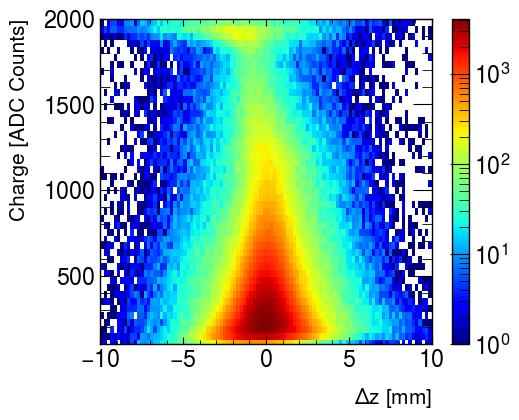

In [4]:
plt.style.use(hep.style.ATLAS)
plt.figure(figsize=(textwidth, 0.5*textheight), dpi = 100)

bins = (100,49)
h_range = [[-10, 10], [0, 2000]]
ret = plt.hist2d(res, charge, bins=(bins), range=h_range, cmap = cm.jet,norm = LogNorm())
plt.colorbar()
plt.xlabel(r"$\Delta$z [mm]", fontsize = fontsize)
plt.ylim(100, 2000)
plt.ylabel("Charge [ADC Counts]", fontsize = fontsize)
# plt.legend()
plt.tight_layout()
# # plt.savefig(f'charge_vs_zres_{run}_timeFit.png', dpi = 600)
# # plt.savefig(f'charge_vs_zres_{run}_timeFit.pdf', dpi = 600)
plt.show()

In [5]:
mean_core = []
mean_tail = []
mean_core_err = []
mean_tail_err = []
std = []
std_err = []

par_tot = []
cov_tot = []

for i in range(len(ret[2])-1):
    # print(i)
    par, cov = Hist2DFitXSlice(ret, i, bigaus, p0 = [1,1,1, 1, 1, 1])
    par_tot.append(par)
    cov_tot.append([cov[i][i] for i in range(6)])
    sigmas = [abs(par[2]), abs(par[5])]
    means = [par[1], par[4]]
    means_err =  [cov[1][1], cov[4][4]]
    covs = [cov[2][2], cov[5][5]]
    mean_core.append(means[np.argmin(sigmas)])
    mean_tail.append(means[np.argmax(sigmas)])
    mean_core_err.append(means_err[np.argmin(sigmas)])
    mean_tail_err.append(means_err[np.argmax(sigmas)])
    std.append(abs(min(sigmas)))
    # means_err.append(np.sqrt(cov[1][1]))
    std_err.append(np.sqrt(covs[np.argmin(sigmas)]))


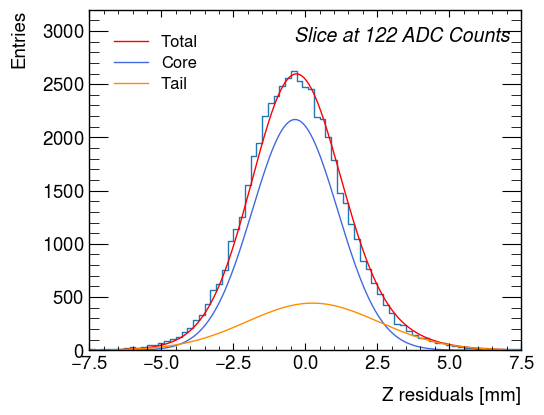

In [6]:
i = 3
plt.figure(figsize=(textwidth, 0.5*textheight), dpi = 100)
Hist2DPlotXSlice(ret, i)
par, cov = Hist2DFitXSlice(ret, i, bigaus, p0 = [1,1,1,1,1,1])
x = np.linspace(-20, 20, 500)
plt.plot(x, bigaus(x, *par), color = 'red', lw = 1, label = 'Total')
plt.plot(x, normal(x, *par[3:]), color = 'royalblue', lw = 1, label = 'Core')
plt.plot(x, normal(x, *par[0:3]), color = 'darkorange', lw = 1, label = 'Tail')

# plt.xlabel('z residues [mm]', fontsize = 15)
plt.ylabel('Entries', fontsize = 0.9*15)
plt.xlabel('Z residuals [mm]', fontsize = 0.9*15)
plt.xlim(-7.5,7.5)
plt.ylim(0, 3200)
plt.tick_params(labelsize = 0.9*fontsize)

ax = plt.gca()

x = ax.get_xlim()[1]*(1-0.05)
y = ax.get_ylim()[1]*(1-0.05)
text = f'Slice at {int(i*(h_range[1][1]-h_range[1][0])/bins[1])} ADC Counts'
plt.text(x = x, y = y, s = text, fontstyle = 'italic', 
             horizontalalignment = 'right', verticalalignment = 'top')

plt.legend(fontsize = 0.8*fontsize, loc = 'upper left')
# plt.savefig('ExampleSliceZResidues.png', dpi = 600)
# plt.savefig('ExampleSliceZResidues.pdf', dpi = 600)
# print(par)
# print([cov[i][i] for i in range(6)])

In [7]:
# def poly(x, a, b, c, d):
#     return a*np.exp(-(x-b)/(c)) + d

def f1(x, a0, a1, a2):
    return a0 + a1/x + a2/x**2

In [8]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

end_idx = 1
x = np.array(ret[2][2:-end_idx-1])
y = np.array(std[2:-end_idx])
err_y = np.array(std_err[2:-end_idx])

ls = LeastSquares(x, y, err_y, f1)
m = Minuit(ls, 0.8,1,1)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 408.6 (χ²/ndof = 9.5)      │              Nfcn = 73               │
│ EDM = 2.55e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │   0.680   │   0.007   │            │            │         │         │       │
│ 1 │ a1   │    95     │     5     │            │            │         │         │       │
│ 2 │ a2   │  -0.2e3   │   0.6e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │        a0        a1        a2 │
├────┼───────────────────────────────┤
│ a0 │  5.12e-05 -29.44e-3   3.01699 │
│ a1 │ -29.44e-3      20.3  -2.366e3 │
│ a2 │   3.01699  -2.366e3   3.4e+05 │
└────┴───────────────────────────────┘

In [9]:
drift_speed = 0.10404849420511054
drift_speed_err = 0.01 * 0.20784864


In [10]:
params = m.values
cov_matrix = m.covariance

# Specific x value
x_generic = mean_charge  # Your specific x value

# Calculate the value of y at x_generic
y_generic = f1(x_generic, *params)

# Gradient of the model with respect to parameters at x_generic
gradient = np.array([1, 1/x_generic, 1/x_generic**2])

# Calculate the variance of y_generic
variance_y_generic = np.dot(gradient, np.dot(cov_matrix, gradient))

# Standard deviation (error) in y_generic
error_y_generic = np.sqrt(variance_y_generic)

print(f"sigma_z({x_generic}) = {y_generic} ± {error_y_generic}")
print(f"sigma_t({x_generic}) = {y_generic/drift_speed} ± {error_y_generic/drift_speed} ± {drift_speed_err*y_generic/(drift_speed**2)}")

sigma_z(467.69534943229587) = 0.8817410396545656 ± 0.002594160391420013
sigma_t(467.69534943229587) = 8.474327729494977 ± 0.024932224259835524 ± 0.1692842848852401


C:\Users\Ospite\AppData\Local\Temp\ipykernel_13628\594492271.py:5: RuntimeWarning: divide by zero encountered in divide
  return a0 + a1/x + a2/x**2
C:\Users\Ospite\AppData\Local\Temp\ipykernel_13628\594492271.py:5: RuntimeWarning: invalid value encountered in add
  return a0 + a1/x + a2/x**2


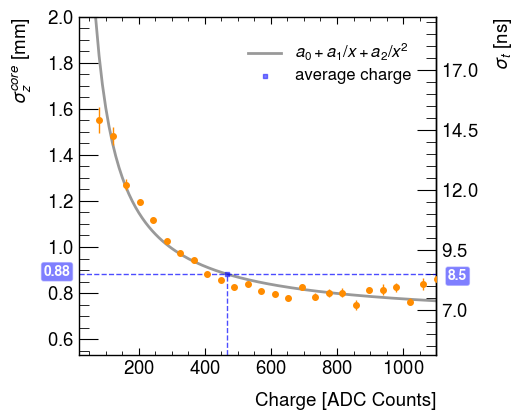

In [11]:
plt.style.use(hep.style.ATLAS)
plt.rc('text', usetex=False)
fig = plt.figure(figsize=(textwidth, 0.5*textheight), dpi = 100)
ax = plt.subplot()

ax.tick_params(right = False, labelright = False,  which = 'both', labelsize = 0.9*fontsize)

x = np.array(ret[2][2:-1])
y = np.array(std[2:])
err_y = np.array(std_err[2:])

ax.errorbar(x[0:-20], y[0:-20], err_y[0:-20], zorder = 5, fmt = '.', color = 'darkorange', capsize=0, lw = 1)
x = np.linspace(0, 2000, 200)
# ax.plot(x, f1(x, *m.values), color = 'grey', zorder = 0, alpha = 0.8, label = r'$a_0 + a_1/x + a_2/x^2$')
ax.plot(x, f1(x, 0.680, 95, -200), color = 'grey', zorder = 0, alpha = 0.8, label = r'$a_0 + a_1/x + a_2/x^2$')
ax.set_ylabel(r"$\sigma^{core}_z$ [mm]", fontsize = 0.9*fontsize)
ax.set_xlabel("Charge [ADC Counts]", fontsize = 0.9*fontsize)
ax.set_ylim(0.53, 2.)
ax.set_xlim(20., 1100)


def z2t(x):
    return x/drift_speed


def t2z(x):
    return x*drift_speed

secax = ax.secondary_yaxis('right', functions=(z2t, t2z))
secax.set_ylabel(r'$\sigma_t$ [ns]', fontsize = 0.9*fontsize)
secax_ticks = [7, 9.5, 12, 14.5, 17]
secax_labels = [str(tick) for tick in secax_ticks]
secax.set_yticks(secax_ticks)
secax.tick_params(which = 'both', labelsize = 0.9*fontsize)

plt.vlines(mean_charge, 0, f1(mean_charge, *m.values), lw = 1, color = 'blue', alpha = 0.7, linestyles='dashed')
plt.hlines(f1(mean_charge, *m.values), 20, 1100, lw = 1, color = 'blue', alpha = 0.7, linestyles='dashed', clip_on=False,)

# ax.annotate(f'{int(mean_charge)} ADC counts', xy=(mean_charge,0.8*f1(mean_charge, *m.values)), xytext=(0.95*mean_charge,1.05*f1(mean_charge, *m.values)), 
            # arrowprops=dict(arrowstyle="->", color='red', connectionstyle="arc3,rad=-0.3"),
            # fontsize=10, color = 'blue')

plt.scatter(mean_charge, f1(mean_charge, *m.values), color = 'blue', alpha = 0.5, marker ='s', clip_on=False, s = 7, label = 'average charge')

# plt.plot(1199, f1(mean_charge, *m.values), color = 'blue', alpha = 0.5, marker ='o', clip_on=False, markersize = 5)
bbox_props = dict(boxstyle='round,pad=0.2', fc='blue', ec='white', lw=1, alpha = 0.5)
plt.figtext(0.84, 0.35, f'{z2t(f1(mean_charge, *m.values)):.1f}', ha='left', va='center', fontsize=10, color = 'white', fontweight='bold',bbox=bbox_props, transform=plt.gcf().transFigure)

# plt.plot(20, f1(mean_charge, *m.values), color = 'blue', alpha = 0.5, marker ='o', clip_on=False, markersize = 5)
bbox_props = dict(boxstyle='round,pad=0.2', fc='blue', ec='white', lw=1, alpha = 0.5)
plt.figtext(0.1, 0.36, f'{f1(mean_charge, *m.values):.2f}', ha='left', va='center', fontsize=10, color = 'white', fontweight='bold',bbox=bbox_props, transform=plt.gcf().transFigure)

plt.legend(fontsize = 0.8*fontsize)
plt.tight_layout()
# plt.savefig(f'Zres_vs_charge_{run}_timefit_bigaus.png', dpi = 600)
# plt.savefig(f'Zres_vs_charge_{run}_timefit_bigaus.pdf', dpi = 600)

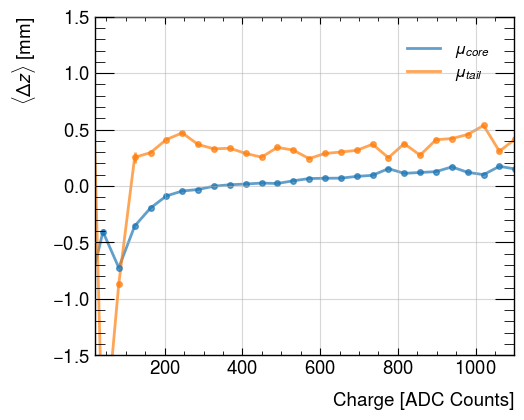

In [12]:
plt.style.use(hep.style.ATLAS)
fig = plt.figure(figsize=(textwidth, 0.5*textheight), dpi = 100)
ax = plt.subplot()


(plt1, ) = ax.plot(ret[2][0:-1], mean_core, alpha = 0.7,label = r'$\mu_{core}$')
(plt2, ) = ax.plot(ret[2][0:-1], mean_tail, alpha = 0.7, label = r'$\mu_{tail}$')
ax.errorbar(ret[2][0:-1], mean_core, yerr = np.array(mean_core_err), fmt  = 'o', alpha = 0.7, markersize = 4, color = plt1.get_color())
ax.errorbar(ret[2][0:-1], mean_tail, yerr = np.array(mean_tail_err),  fmt = 'o', alpha = 0.7, markersize = 4, color = plt2.get_color())

ax.set_ylim(-1.5, 1.5)
ax.set_xlim(20, 1100)
ax.set_xlabel("Charge [ADC Counts]", fontsize = 0.9*fontsize)
ax.set_ylabel(r"$\langle{\Delta z}\rangle$ [mm]", fontsize = 0.9*fontsize)
ax.tick_params(labelsize = 0.9*fontsize)


plt.grid(alpha = 0.5)
plt.tight_layout()
plt.legend(fontsize = 0.8*fontsize)
# plt.savefig(f'Zresmean_vs_charge_{run}_timefit.png', dpi = 600)
# plt.savefig(f'Zresmean_vs_charge_{run}_timefit.pdf', dpi = 600)
# plt.show()

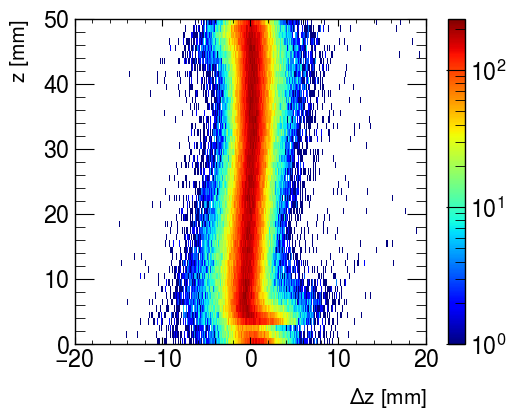

In [13]:
plt.style.use(hep.style.ATLAS)
plt.figure(figsize=(textwidth, 0.5*textheight), dpi = 100)
fontsize = 15

bins = (1000,50)
h_range = [[-20, 20], [0, 50]]
ret = plt.hist2d(res, z, bins=(bins), range=h_range, cmap = cm.jet,norm = LogNorm())
plt.colorbar()
plt.xlabel(r"$\Delta$z [mm]", fontsize = 15)
plt.ylim(0, 50)
plt.ylabel("z [mm]", fontsize = 15)
# plt.legend()
plt.tight_layout()
# # plt.savefig(f'z_vs_resz_{run}_timeFit.png', dpi = 600)
# # plt.savefig(f'z_vs_resz_{run}timeFit.pdf', dpi = 600)
plt.show()

In [14]:
mean_tail = []
mean_core = []
mean_tail_err = []
mean_core_err = []
std_core = []
std_core_err = []

for i in range(len(ret[2])-1):
    # Hist2DPlotXSlice(ret, i)
    # plt.show()
    par, cov = Hist2DFitXSlice(ret, i, bigaus, [1,1,1, 1, 1, 1])
    sigmas = [abs(par[2]), abs(par[5])]
    means = [par[1], par[4]]
    means_err =  [cov[1][1], cov[4][4]]
    covs = [cov[2][2], cov[5][5]]
    mean_core.append(means[np.argmin(sigmas)])
    mean_tail.append(means[np.argmax(sigmas)])
    mean_core_err.append(means_err[np.argmin(sigmas)])
    mean_tail_err.append(means_err[np.argmax(sigmas)])
    std_core.append(abs(min(sigmas)))
    std_core_err.append(np.sqrt(covs[np.argmin(sigmas)]))

In [16]:
def line(x, m, q):
    return m*x+q

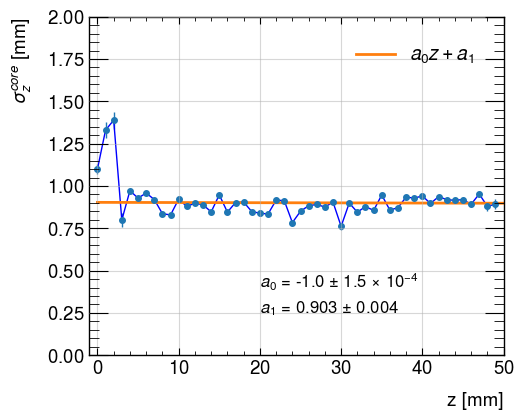

In [69]:
plt.style.use(hep.style.ATLAS)
plt.figure(figsize=(textwidth, 0.5*textheight), dpi = 100)
fontsize = 15

ax = plt.gca()
ax.tick_params(labelsize = 0.9*fontsize)
# plt.figure(dpi = 100)
plt.errorbar(ret[2][0:-1], std_core, yerr = std_core_err, capsize=0, fmt = '.', lw = 1)
plt.plot(ret[2][0:-1], std_core, lw = 1, color = 'blue')

par, cov = curve_fit(line, ret[2][0:-1], std_core, absolute_sigma=True, sigma = std_core_err)
x_values = np.linspace(0, 50, 2)
plt.plot(x_values, line(x_values, *par), label = r'$a_0 z+ a_1$')
# print(par)
par_err = np.sqrt(np.diag(cov))

plt.text(20, 0.4, s = rf'$a_0$ = {par[0]*10000:.1f} $\pm$ {par_err[0]*10000:.1f} $\times$ $10^{{-4}}$ ', fontsize = 0.8*fontsize)
plt.text(20, 0.25, s = rf'$a_1$ = {par[1]:.3f} $\pm$ {par_err[1]:.3f}', fontsize = 0.8*fontsize)


plt.ylabel(r"$\sigma^{core}_z$ [mm]", fontsize = 0.9*fontsize)
plt.xlim(-1, 50)
plt.ylim(0, 2)
plt.xlabel("z [mm]", fontsize = 0.9*fontsize)
# plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
plt.legend()
plt.savefig(f'longdiff_{run}_timeFit.png', dpi = 600)
plt.savefig(f'longdiff_{run}timeFit.pdf', dpi = 600)
plt.show()